# Deep Learning Project 3 - Patryk Prusak,  Dutt Salveen Singh

# Imports and Consts

In [8]:
IS_IN_COLAB = False

In [9]:
if IS_IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project3/Dataset/archive.zip -o/content/dataset/

In [10]:
if IS_IN_COLAB:
    !pip install torchmetrics
    !pip install diffusers
    !pip install torch-fidelity
    !pip install torchmetrics[image]
    !pip install torch-fidelity

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import pickle
import math

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import transforms
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel

from tqdm.auto import tqdm
from enum import Enum
from IPython.display import clear_output

In [12]:
if IS_IN_COLAB:
    DATASET_PATH = "/content/dataset/data0/lsun/bedroom/"
    DEVICE = "cuda:0"
    import shutil
else:
    DATASET_PATH = "../Dataset/data0/lsun/bedroom/"
    DEVICE = "cpu"

# Functions

In [55]:
class LSUNBedroomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.transform = transform
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def getTrainTestDataset(root_dir, transform=None, limit=1, test_size=0.1):
    image_paths = []

    # Traverse the directory to get image paths
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(("png", "jpg", "jpeg")):
                image_paths.append(os.path.join(subdir, file))
    image_paths = image_paths[: int(limit * len(image_paths))]

    return LSUNBedroomDataset(
        image_paths[int(test_size * len(image_paths)) :], transform
    ), LSUNBedroomDataset(image_paths[: int(test_size * len(image_paths))], transform)


class SMLDScheduler:
    def __init__(self, num_train_timesteps):
        self.num_train_timesteps = num_train_timesteps
        self.config = lambda: None
        self.config.num_train_timesteps = num_train_timesteps
        self.device = torch.device(DEVICE)

    def add_noise(self, images, noise, timesteps):
        alphas = self.get_alpha(timesteps).unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return images + alphas * noise

    def get_alpha(self, t):
        # Convert t to a tensor if it's an integer
        if isinstance(t, int):
            t = torch.tensor([t], device=self.device)
        # Ensure t is a long tensor
        t = t.long()
        return torch.linspace(1e-4, 0.02, self.num_train_timesteps).to(self.device)[t]


class ModelType(Enum):
    DDPM = 1

    SMLD = 2


class NoiseSchedulerType(Enum):
    DDPMSched = 1

    SMLDSched = 2


class OptimizerType(Enum):
    Adam = 1

    SGD = 2

    AdaDelta = 3


def set_seed(seed=0):
    np.random.seed(seed)
    # random.seed(seed)
    torch.manual_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISM"] = "1"
    os.environ["PYTHONHASHSEED"] = str(seed)


def namestr(obj, namespace) -> str:
    """Get name of a variable as a string"""
    return [name for name in namespace if namespace[name] is obj]


def getOptimizer(optimzierType: OptimizerType, model, params):
    match optimzierType:
        case OptimizerType.Adam:
            return torch.optim.Adam(model.parameters(), **params)
        case OptimizerType.SGD:
            return torch.optim.SGD(model.parameters(), **params)
        case OptimizerType.AdaDelta:
            return torch.optim.Adadelta(model.parameters(), **params)


def getScheduler(schedulerType: NoiseSchedulerType, params):
    match schedulerType:
        case NoiseSchedulerType.DDPMSched:
            return DDPMScheduler(**params)
        case NoiseSchedulerType.SMLDSched:
            return SMLDScheduler(**params)


def getModel(modelType: ModelType, device):
    match modelType:
        case ModelType.DDPM:
            model = UNet2DModel(
                sample_size=32,  # the target image resolution
                in_channels=3,  # the number of input channels, 3 for RGB images
                out_channels=3,  # the number of output channels
                layers_per_block=1,
                block_out_channels=(32, 64, 128),
                down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
                up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
            )
            model = model.to(device)
            return model
        case ModelType.SMLD:
            model = UNet2DModel(
                sample_size=32,
                in_channels=3,
                out_channels=3,
                layers_per_block=1,
                block_out_channels=(32, 64, 128),
                down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
                up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
            )
            model = model.to(device)
            return model


def trainModel(model, num_epochs, dataloader, optimizer, device, noise_scheduler):
    for epoch in range(num_epochs):
        model.train()
        for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            batch = batch.to(device)
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (batch.size(0),),
                device=device,
            ).long()
            noise = torch.randn_like(batch)
            noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)

            noise_pred = model(noisy_images, timesteps).sample

            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} completed. Loss: {loss.item()}")


def generateImages(
    model,
    device,
    noise_scheduler,
    num_epochs,
    output_dir,
    num_images,
    metric,
    test_image_tensors,
):
    model.eval()

    for test_image_tensor in test_image_tensors:
        metric.update(
            transforms.Resize((64, 64))(test_image_tensor)
            .unsqueeze(0)
            .type(torch.uint8)
            .to(device),
            True,
        )
    generated_images = []

    with torch.no_grad():
        for _ in tqdm(range(num_images), desc="Generating Images"):
            noisy_image = torch.randn(1, 3, 32, 32, device=device)
            for t in reversed(
                range(noise_scheduler.config.num_train_timesteps)
            ):  # Access via config
                timesteps = torch.full((1,), t, device=device, dtype=torch.long)
                model_output = model(noisy_image, timesteps)
                t = torch.tensor([t], device=device)
                # Ensure t is a long tensor
                t = t.long()
                noisy_image = noise_scheduler.add_noise(
                    model_output.sample, noisy_image, t
                )

            generated_image = noisy_image.squeeze(0).cpu()
            metric.update(noisy_image.type(torch.uint8).to(device), False)

            generated_images.append(generated_image.to(device))

    # Saving generated images
    os.makedirs(output_dir, exist_ok=True)

    for idx, image in enumerate(generated_images):
        save_image(image, f"{output_dir}/generated_image_{idx+1}.png")

    print(f"{num_images} images generated and saved in {output_dir}")


def conductSingleExperiment(
    modelType,
    device,
    seed,
    optimizerType,
    learningRate,
    scheduclerType,
    trainingSteps,
    numberOfEpochs,
    trainDataloader,
    testDataset,
    experimentCount,
):

    set_seed(seed)
    model = getModel(modelType=modelType, device=device)
    optimizer = getOptimizer(optimizerType, model, {"lr": learningRate})
    scheduler = getScheduler(
        schedulerType=scheduclerType,
        params={"num_train_timesteps": trainingSteps},
    )

    trainModel(
        model,
        numberOfEpochs,
        trainDataloader,
        optimizer,
        device,
        scheduler,
    )
    metric = FrechetInceptionDistance(feature=64)
    metric = metric.to(device)
    generateImages(
        model,
        device,
        scheduler,
        numberOfEpochs,
        f"./Results/{modelType.name}/{experimentCount}",
        10,
        metric,
        list(testDataset),
    )
    clear_output(wait=True)
    return metric.compute()


def performExperiments(
    modelType,
    numberOfEpochs,
    trainDataset,
    testDataset,
    optimizerTypes,
    learningRates,
    device,
    schedulerTypes,
    trainingSteps,
    seeds,
    batchSizes,
):

    metric = math.inf
    currentBestNumberOfEpochs = numberOfEpochs[0]
    currentBestOptimizer = optimizerTypes[0]
    currentBestScheduler = schedulerTypes[0]
    currentBestLearningRate = learningRates[0]
    currentBestTrainingSteps = trainingSteps[0]
    currentBestBatchSize = batchSizes[0]

    experimentCount = 0

    results = []

    for learningRate in learningRates:
        for optimizerType in optimizerTypes:
            currentMetrics = []
            for seed in seeds:
                dataloader = DataLoader(
                    trainDataset, batch_size=currentBestBatchSize, shuffle=True
                )
                fid = conductSingleExperiment(
                    modelType,
                    device,
                    seed,
                    optimizerType,
                    learningRate,
                    currentBestScheduler,
                    currentBestTrainingSteps,
                    currentBestNumberOfEpochs,
                    dataloader,
                    testDataset,
                    experimentCount,
                )

                experimentCount = experimentCount + 1

                currentMetrics.append(fid.item())

                results.append(
                    [
                        modelType.name,
                        currentBestNumberOfEpochs,
                        optimizerType.name,
                        learningRate,
                        currentBestScheduler.name,
                        currentBestTrainingSteps,
                        seed,
                        fid.item(),
                        "OptimizerBatch",
                        currentBestBatchSize,
                    ]
                )
            if np.mean(currentMetrics) < metric:
                metric = np.mean(currentMetrics)
                currentBestLearningRate = learningRate
                currentBestOptimizer = optimizerType

    for trainingStep in trainingSteps:
        for schdulerType in schedulerTypes:
            currentMetrics = []
            for seed in seeds:
                dataloader = DataLoader(
                    trainDataset, batch_size=currentBestBatchSize, shuffle=True
                )
                fid = conductSingleExperiment(
                    modelType,
                    device,
                    seed,
                    currentBestOptimizer,
                    currentBestLearningRate,
                    schdulerType,
                    trainingStep,
                    currentBestNumberOfEpochs,
                    dataloader,
                    testDataset,
                    experimentCount,
                )

                experimentCount = experimentCount + 1

                currentMetrics.append(fid.item())

                results.append(
                    [
                        modelType.name,
                        currentBestNumberOfEpochs,
                        currentBestOptimizer.name,
                        currentBestLearningRate,
                        schdulerType.name,
                        trainingStep,
                        seed,
                        fid.item(),
                        "SchedulerBatch",
                        currentBestBatchSize,
                    ]
                )
            if np.mean(currentMetrics) < metric:
                metric = np.mean(currentMetrics)
                currentBestTrainingSteps = trainingStep
                currentBestScheduler = schdulerType

    for numberOfEpoch in numberOfEpochs:
        currentMetrics = []
        for seed in seeds:
            dataloader = DataLoader(
                trainDataset, batch_size=currentBestBatchSize, shuffle=True
            )
            fid = conductSingleExperiment(
                modelType,
                device,
                seed,
                currentBestOptimizer,
                currentBestLearningRate,
                currentBestScheduler,
                currentBestTrainingSteps,
                numberOfEpoch,
                dataloader,
                testDataset,
                experimentCount,
            )

            experimentCount = experimentCount + 1

            currentMetrics.append(fid.item())

            results.append(
                [
                    modelType.name,
                    numberOfEpoch,
                    currentBestOptimizer.name,
                    currentBestLearningRate,
                    currentBestScheduler.name,
                    currentBestTrainingSteps,
                    seed,
                    fid.item(),
                    "EpochBatch",
                    currentBestBatchSize,
                ]
            )
        if np.mean(currentMetrics) < metric:
            metric = np.mean(currentMetrics)
            currentBestNumberOfEpochs = numberOfEpoch

    for batchSize in batchSizes:
        currentMetrics = []
        for seed in seeds:
            dataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
            fid = conductSingleExperiment(
                modelType,
                device,
                seed,
                currentBestOptimizer,
                currentBestLearningRate,
                currentBestScheduler,
                currentBestTrainingSteps,
                currentBestNumberOfEpochs,
                dataloader,
                testDataset,
                experimentCount,
            )

            experimentCount = experimentCount + 1

            currentMetrics.append(fid.item())

            results.append(
                [
                    modelType.name,
                    numberOfEpoch,
                    currentBestOptimizer.name,
                    currentBestLearningRate,
                    currentBestScheduler.name,
                    currentBestTrainingSteps,
                    seed,
                    fid.item(),
                    "BatchBatch",
                    batchSize,
                ]
            )
        if np.mean(currentMetrics) < metric:
            metric = np.mean(currentMetrics)
            currentBestBatchSize = batchSize

    return results, [
        currentBestNumberOfEpochs,
        currentBestOptimizer,
        currentBestScheduler,
        currentBestLearningRate,
        currentBestTrainingSteps,
        currentBestBatchSize,
    ]


def processParametersFilteredResults(resultsDf, model):

    # Optimizer type and learning rate

    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "OptimizerBatch"],
        x="Optimizer",
        y="FID",
        hue="Learning rate",
        showfliers=False,
    )
    title = str(model.name) + " - FID per optimzier per learning rate - filtered"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()

    # Number of epochs

    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "EpochBatch"],
        x="Number of epochs",
        y="FID",
        showfliers=False,
    )
    title = str(model.name) + " - FID per number of epochs - filtered"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()

    # Scheduler
    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "SchedulerBatch"],
        x="Scheduler",
        y="FID",
        hue="Training steps",
        showfliers=False,
    )
    title = str(model.name) + " - FID per Scheduler by Training steps - filtered"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()

    # Batch size
    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "BatchBatch"],
        x="Batch size",
        y="FID",
        showfliers=False,
    )
    title = str(model.name) + " - FID per Batch size - filtered"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()


def processParametersFilteredResultsCombined(resultsDf):

    grouped = resultsDf.groupby("Model")

    for name, group in grouped:

        # Optimizer type and learning rate

        sns.boxplot(
            data=group[group["Section"] == "OptimizerBatch"],
            x="Optimizer",
            y="FID",
            hue="Learning rate",
            showfliers=False,
        )
        title = str(name) + " - FID per optimzier per learning rate"
        plt.title(title)
        plt.tight_layout()
        plt.savefig(title + ".png", format="png", bbox_inches="tight")
        if IS_IN_COLAB:
            shutil.copy(
                "/content/" + title + ".png",
                "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
            )
        plt.show()

    # Number of epochs

    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "EpochBatch"],
        x="Number of epochs",
        y="FID",
        hue="Model",
        showfliers=False,
    )
    title = "FID per number of epochs"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()

    # Scheduler
    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "SchedulerBatch"],
        x="Scheduler",
        y="FID",
        hue="Training steps",
        showfliers=False,
    )
    title = "FID per Scheduler by Training steps"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()

    # Batch size
    sns.boxplot(
        data=resultsDf[resultsDf["Section"] == "BatchBatch"],
        x="Batch size",
        y="FID",
        hue="Model",
        showfliers=False,
    )
    title = "FID per Batch size"
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
        )
    plt.show()

# Experiments

## Prepare the dataset

In [56]:
# Define transforms
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

# Create dataset
trainDataset, testDataset = getTrainTestDataset(DATASET_PATH, transform, 0.003, 0.1)

## DDPM

### Experiments

In [57]:
# Parameters
# 1. Different Optimizers and Learning rates
# 2. Number of training steps
# 3. Number of epochs
modelType = ModelType.DDPM

device = torch.device(DEVICE)

learningRates = [0.0001, 0.001, 0.01]
# learningRates = [0.0001]

optimizers = [OptimizerType.Adam, OptimizerType.AdaDelta, OptimizerType.SGD]
# optimizers = [OptimizerType.Adam]

trainingSteps = [200, 500, 1000]
# trainingSteps = [200]

numberOfEpochs = [2, 5, 10]
# numberOfEpochs = [1]

schedulerTypes = [NoiseSchedulerType.DDPMSched]
seeds = [1, 42, 120, 37, 199]
# seeds = [42]

batchSizes = [128, 64, 32]

In [ ]:
%%time
# Experiments

results, best = performExperiments(
    modelType,
    numberOfEpochs,
    trainDataset,
    testDataset,
    optimizers,
    learningRates,
    device,
    schedulerTypes,
    trainingSteps,
    seeds,
    batchSizes,
)
with open(f"{modelType.name}-results", "wb") as my_csv:
    pickle.dump(results, my_csv)

if IS_IN_COLAB:
    shutil.copy(
        f"/content/{modelType.name}-results",
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
    )

with open(f"{modelType.name}-best", "wb") as my_csv:
    pickle.dump(best, my_csv)

if IS_IN_COLAB:
    shutil.copy(
        f"/content/{modelType.name}-best",
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
    )

In [47]:
if IS_IN_COLAB:
    if (
        os.path.exists(
            f"/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/Images/{modelType.name}"
        )
        == False
    ):
        os.mkdir(
            f"/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/Images/{modelType.name}"
        )
    shutil.copytree(
        f"/content/Results/{modelType.name}",
        f"/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/Images/{modelType.name}",
        dirs_exist_ok=True,
    )

### Results

In [48]:
if IS_IN_COLAB:
    with open(f"/content/{modelType.name}-results", "rb") as input_file:
        results = pickle.load(input_file)
else:
    with open(f"{modelType.name}-results", "rb") as input_file:
        results = pickle.load(input_file)

if IS_IN_COLAB:
    with open(f"/content/{modelType.name}-best", "rb") as input_file:
        best = pickle.load(input_file)
else:
    with open(f"{modelType.name}-best", "rb") as input_file:
        best = pickle.load(input_file)

FileNotFoundError: [Errno 2] No such file or directory: 'DDPM-results'

In [ ]:
resultsColumns = [
    "Model",
    "Number of epochs",
    "Optimizer",
    "Learning rate",
    "Scheduler",
    "Training steps",
    "Seed",
    "FID",
    "Section",
    "Batch size",
]

bestColumns = [
    "Number of epochs",
    "Optimizer",
    "Scheduler",
    "Learning rate",
    "Training steps",
    "Batch size",
]

In [ ]:
resultsDf = pd.DataFrame(results, columns=resultsColumns)
bestDf = pd.DataFrame(best, bestColumns)

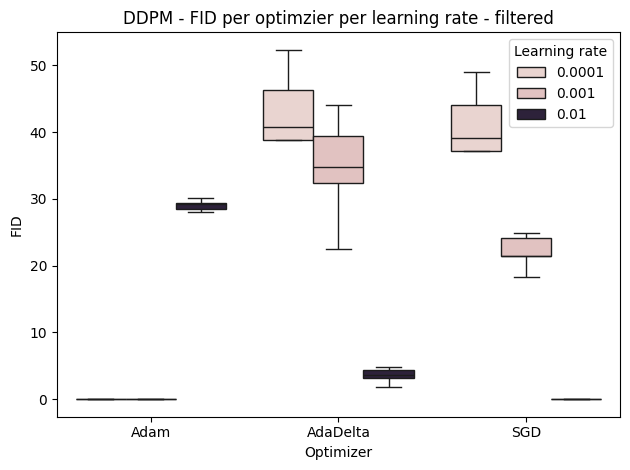

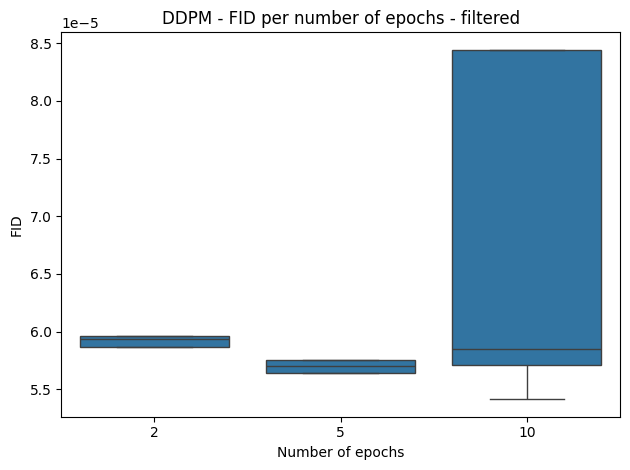

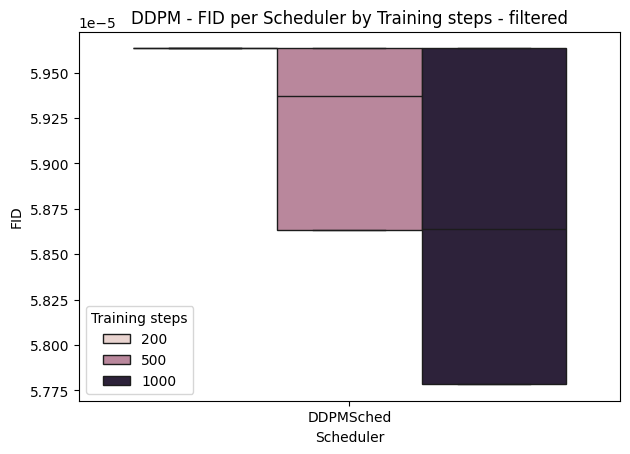

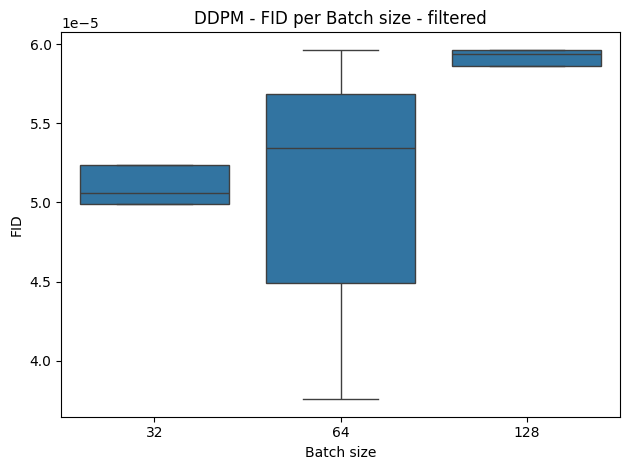

In [ ]:
processParametersFilteredResults(resultsDf, modelType)

In [ ]:
best

[2, <OptimizerType.Adam: 1>, <NoiseSchedulerType.DDPMSched: 1>, 0.001, 500, 64]

## SMLD

### Experiments

In [59]:
# Parameters
# 1. Different Optimizers and Learning rates
# 2. Number of training steps
# 3. Number of epochs
modelType = ModelType.SMLD

device = torch.device(DEVICE)

learningRates = [0.0001, 0.001, 0.01]
# learningRates = [0.0001]

optimizers = [OptimizerType.Adam, OptimizerType.AdaDelta, OptimizerType.SGD]
# optimizers = [OptimizerType.Adam]

trainingSteps = [200, 500, 1000]
# trainingSteps = [200]

numberOfEpochs = [2, 5, 10]
# numberOfEpochs = [1]

schedulerTypes = [NoiseSchedulerType.SMLDSched]
seeds = [1, 42, 120, 37, 199]
# seeds = [42]

batchSizes = [128, 64, 32]

In [60]:
%%time
# Experiments

results, best = performExperiments(
    modelType,
    numberOfEpochs,
    trainDataset,
    testDataset,
    optimizers,
    learningRates,
    device,
    schedulerTypes,
    trainingSteps,
    seeds,
    batchSizes,
)
with open(f"{modelType.name}-results", "wb") as my_csv:
    pickle.dump(results, my_csv)

if IS_IN_COLAB:
    shutil.copy(
        f"/content/{modelType.name}-results",
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
    )

with open(f"{modelType.name}-best", "wb") as my_csv:
    pickle.dump(best, my_csv)

if IS_IN_COLAB:
    shutil.copy(
        f"/content/{modelType.name}-best",
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
    )

Training Epoch 1/2:  43%|████▎     | 3/7 [00:47<01:03, 15.90s/it]


KeyboardInterrupt: 

In [ ]:
if IS_IN_COLAB:
    if (
        os.path.exists(
            f"/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/Images/{modelType.name}"
        )
        == False
    ):
        os.mkdir(
            f"/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/Images/{modelType.name}"
        )
    shutil.copytree(
        f"/content/Results/{modelType.name}",
        f"/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/Images/{modelType.name}",
        dirs_exist_ok=True,
    )

### Results

In [ ]:
if IS_IN_COLAB:
    with open(f"/content/{modelType.name}-results", "rb") as input_file:
        results = pickle.load(input_file)
else:
    with open(f"{modelType.name}-results", "rb") as input_file:
        results = pickle.load(input_file)

if IS_IN_COLAB:
    with open(f"/content/{modelType.name}-best", "rb") as input_file:
        best = pickle.load(input_file)
else:
    with open(f"{modelType.name}-best", "rb") as input_file:
        best = pickle.load(input_file)

FileNotFoundError: [Errno 2] No such file or directory: 'SMLD-results'

In [ ]:
resultsColumns = [
    "Model",
    "Number of epochs",
    "Optimizer",
    "Learning rate",
    "Scheduler",
    "Training steps",
    "Seed",
    "FID",
    "Section",
    "Batch size",
]

bestColumns = [
    "Number of epochs",
    "Optimizer",
    "Scheduler",
    "Learning rate",
    "Training steps",
    "Batch size",
]

In [ ]:
resultsDf = pd.DataFrame(results, columns=resultsColumns)
bestDf = pd.DataFrame(best, bestColumns)

In [ ]:
processParametersFilteredResults(resultsDf, modelType)

In [ ]:
best

# Combine results

In [ ]:
resultsColumns = [
    "Model",
    "Number of epochs",
    "Optimizer",
    "Learning rate",
    "Scheduler",
    "Training steps",
    "Seed",
    "FID",
    "Section",
    "Batch size",
]

bestColumns = [
    "Number of epochs",
    "Optimizer",
    "Scheduler",
    "Learning rate",
    "Training steps",
    "Batch size",
]

In [ ]:
models = [ModelType.DDPM, ModelType.SMLD]
results = []
for model in models:
    if IS_IN_COLAB:
        shutil.copy(
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project3/Results/",
            f"/content/{modelType.name}-results",
        )
    if IS_IN_COLAB:
        with open(f"/content/{model.name}-results", "rb") as input_file:
            results.append(pickle.load(input_file))
    else:
        with open(f"{model.name}-results", "rb") as input_file:
            results.append(pickle.load(input_file))

In [ ]:
results = [x for xs in results for x in xs]
resultsDf = pd.DataFrame(results, columns=resultsColumns)

In [ ]:
processParametersFilteredResultsCombined(resultsDf)

# Disconnect

In [ ]:
if IS_IN_COLAB:
    from google.colab import runtime

    runtime.unassign()